In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

In [3]:
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import mean_absolute_error

import scikitplot as skplt

from datetime import datetime

import xgboost as xgb

import lightgbm as lgb

from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [4]:
train = pd.read_hdf(r'C:\Users\Seba\Documents\python\datasets-pyth\realstate\train.realestate.h5')

In [5]:
train_fillna = train.fillna(-1)

In [6]:
train.head()

,parking,apartament,surroundings,extra_description,benefit_investment,broker_license,broker_id,broker_company_id,building_num_floor,type_building,...,apartament_bahtroom_condition,apartament_installation_condition,apartament_window,apartament_appartament,stats_who,stats_market,stats_created_at,stats_updated_at,stats_viewers,stats_who_cat
0,garaż,"{'Łazienka': 'w aneksie', 'Liczba pokoi': 'par...",{'Zdrowie': [' ...,[OSTATNIE WOLNE LOKALE !!!!!!!!!! OSIED...,NaN,,0,0,3,apartamentowiec,...,-1,nowa,nowe plastikowe,"północno-zachodnie, południowo-wschodnie",osoba prywatna,wtórny,więcej niż miesiąc temu,dzisiaj,2596,0
0,NaN,"{'Liczba pokoi': '8', 'Kuchnia': 'bardzo dobry...",{'Zdrowie': [' ...,[Mieszkanie typu studio na warszawskiej Ochoci...,NaN,,1,1,8,apartamentowiec,...,-1,-1,-1,-1,biuro nieruchomości,wtórny,w tym miesiącu,wczoraj,213,1
0,NaN,"{'Łazienka': 'z oknem, oddzielna', 'Liczba pok...",{'Zdrowie': [' ...,"[Oferujemy mieszkanie na 3 piętrze, dwustronne...",NaN,,2,0,4,blok,...,do odnowienia,częściowo wymieniona,nowe plastikowe,"wschodnie, zachodnie",osoba prywatna,wtórny,w ciągu ostatnich dwóch tygodni,w ciągu ostatnich dwóch tygodni,436,0
0,NaN,"{'Liczba pokoi': 'parter', 'Kuchnia': 'do remo...",{},"[Witam, oferuję Państwu mieszkanie na spokojny...",NaN,Nr licencji pośrednika: 11710,3,2,4,blok,...,-1,-1,-1,-1,biuro nieruchomości,wtórny,więcej niż miesiąc temu,w tym tygodniu,122,1
0,NaN,"{'Liczba pokoi': '3', 'Kuchnia': '3', 'Forma w...",{'Zdrowie': [' ...,[Jeśli chcesz mieszkać w doskonale skomunikowa...,NaN,,4,3,3,blok,...,-1,-1,-1,-1,biuro nieruchomości,wtórny,więcej niż miesiąc temu,wczoraj,1152,1


In [7]:
train = train.reset_index()
train.drop('index',axis=1,inplace=True)

In [17]:
train['price'].describe()

count    1.887600e+04
mean     1.302111e+06
std      7.316672e+07
min     -1.000000e+00
25%      3.600000e+05
50%      5.336660e+05
75%      8.300000e+05
max      1.000000e+10
Name: price, dtype: float64

In [20]:
train['price'].sort_values(ascending=False).head(10)

532      1.000000e+10
9240     1.000000e+09
16575    1.111111e+08
16574    1.111111e+08
16572    1.111111e+08
16568    1.111111e+08
9238     1.000000e+08
7885     1.250000e+07
11788    1.250000e+07
9357     1.000000e+07
Name: price, dtype: float64

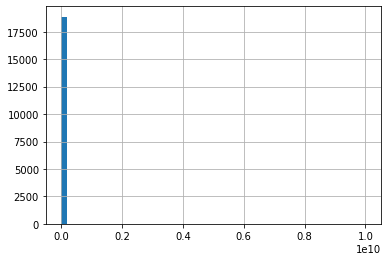

In [23]:
train['price'].hist(bins=50)

In [26]:
np.percentile(train_fillna['price'],99.5)

4200000.0

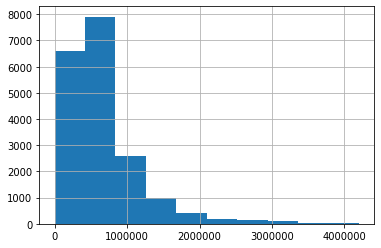

In [28]:
train_fillna[train_fillna['price']< np.percentile(train_fillna['price'],99.5)]['price'].hist()

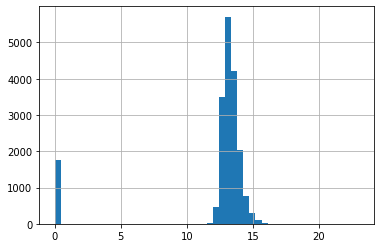

In [12]:
np.log(train['price']+ 2).hist(bins=50)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19144 entries, 0 to 19143
Data columns (total 51 columns):
parking                                  6854 non-null object
apartament                               18874 non-null object
surroundings                             19144 non-null object
extra_description                        16732 non-null object
benefit_investment                       1383 non-null object
broker_license                           19144 non-null object
broker_id                                19144 non-null int16
broker_company_id                        19144 non-null int16
building_num_floor                       19144 non-null int64
type_building                            19144 non-null object
year_building                            19144 non-null int64
material_building                        19144 non-null object
benefit_patio                            19144 non-null int64
benefit_winda                            19144 non-null int64
benefit_loft     

In [86]:
for column in train.columns :
    if column not in ['apartament','surroundings']:
        print(column)
        print('')
        print(train[column].value_counts(normalize=True))
        print('')

parking

garaż                                                                          0.387073
parking podziemny                                                              0.156405
miejsce parkingowe                                                             0.149402
brak                                                                           0.128246
miejsce parkingowe, parking podziemny                                          0.049606
garaż, miejsce parkingowe, parking podziemny                                   0.027867
parking strzeżony                                                              0.024365
garaż, miejsce parkingowe                                                      0.015611
płatny dodatkowo                                                               0.012402
parking podziemny, płatny dodatkowo                                            0.012402
możliwość wynajęcia                                                            0.010943
parking podziemny, brak

Name: extra_description, Length: 16277, dtype: float64

benefit_investment

winda, recepcja, ochrona, teren ogrodzony                                                                                                                                              0.139552
telefon, internet, winda, patio, ogrzewanie miejskie, recepcja, ochrona, teren ogrodzony                                                                                               0.110629
wideofon, podjazd dla niepełnosprawnych                                                                                                                                                0.096168
telefon, internet, TV kablowa, winda, ogrzewanie miejskie, recepcja, domofon, ochrona, teren ogrodzony                                                                                 0.073030
winda, teren ogrodzony                                                                                                                                      

Name: broker_license, Length: 330, dtype: float64

broker_id

2       0.150543
111     0.035364
97      0.021521
217     0.013320
56      0.012380
          ...   
103     0.000052
87      0.000052
39      0.000052
1350    0.000052
0       0.000052
Name: broker_id, Length: 1505, dtype: float64

broker_company_id

5      0.044557
6      0.037923
97     0.037401
0      0.037035
43     0.036983
         ...   
247    0.000052
295    0.000052
311    0.000052
327    0.000052
359    0.000052
Name: broker_company_id, Length: 404, dtype: float64

building_num_floor

 4     0.221949
 3     0.165744
 5     0.088905
 6     0.081383
 2     0.070100
 10    0.067959
 7     0.058243
 8     0.049990
-1     0.045393
 11    0.026431
 12    0.024028
 9     0.022200
 15    0.015357
 25    0.010708
 1     0.010343
 14    0.009559
 17    0.009455
 13    0.007783
 16    0.005903
 30    0.003813
 22    0.001410
 20    0.001097
 18    0.000679
 19    0.000470
 21    0.000366
 23    0.000313
 24    0.000209
 28

Name: apartament_num_levels, dtype: float64

apartament_finished

-1                       0.986053
stan developerski        0.013007
wykonanie pod klucz      0.000575
stan surowy zamknięty    0.000261
bez białego montażu      0.000104
Name: apartament_finished, dtype: float64

apartament_condition

-1                 0.471114
bardzo dobry       0.173579
dobry              0.056885
do remontu         0.055370
po remoncie        0.053176
idealny            0.048266
do wykończenia     0.046333
do odświeżenia     0.044296
wysoki standard    0.038602
w budowie          0.006007
do odnowienia      0.005955
odnowione          0.000418
Name: apartament_condition, dtype: float64

apartament_noise

-1                     0.754753
ciche                  0.180579
umiarkowanie ciche     0.060698
umiarkowanie głośne    0.003186
głośne                 0.000784
Name: apartament_noise, dtype: float64

apartament_kitchen

-1                                                            0.609643
w aneksie 

In [58]:
get_feats(df_modified)

['broker_id',
 'broker_company_id',
 'building_num_floor',
 'type_building',
 'year_building',
 'material_building',
 'benefit_patio',
 'benefit_winda',
 'benefit_loft',
 'benefit_wideofon',
 'benefit_tv_kablowa',
 'benefit_recepcja',
 'benefit_centralne_ogrzewanie',
 'benefit_ogrzewanie_miejskie',
 'benefit_internet',
 'benefit_ogrzewanie_elektryczne',
 'benefit_teren_ogrodzony',
 'benefit_podjazd_dla_niepełnosprawnych',
 'benefit_ochrona',
 'benefit_telefon',
 'benefit_ogrzewanie_podłogowe',
 'benefit_antresola',
 'benefit_domofon',
 'apartament_area',
 'apartament_num_rooms',
 'stats_viewers',
 'stats_who_cat',
 'garaż',
 'parking podziemny',
 'miejsce parkingowe',
 'brak',
 'powierzchnia']

In [31]:
def get_feats(df):
    #feats = df.select_dtypes(include=[np.number,np.bool]).columns

    black_list= ['broker_license','parking', 'apartament', 'surroundings', 'extra_description',
       'benefit_investment', 'price', 'apartament_fix', 'apartament_condition','apartament_kitchen', 'apartament_bathroom',
       'apartament_bahtroom_condition', 'apartament_installation_condition',
       'apartament_window', 'apartament_appartament', 'stats_created_at', 'stats_updated_at', 'stats_viewers']
    
    return [feat for feat in df.columns if feat not in black_list ] 
    
def parking_feats(x,feat):
    
    if feat in x:
        return 1
    elif x== '-1':
        return -1
    else:
        return 0
    
    
def prepare_feat(x,feat):
    if type(x) != dict:
        return -1
    else:
        if feat in x.keys():
            return x[feat]
        else:
            return -1

def string_feats(x,feat):
    if x == -1:
        return 0
    else:
        if feat in str(x):
            return 1
        else: 
            return 0
        
        

    
def feature_engineering(df):
    
    df_modified = train.fillna(-1)
    
    df_modified['garaż'] = df_modified['parking'].apply(lambda x: parking_feats(str(x),'garaż') )
    df_modified['parking_podziemny'] = df_modified['parking'].apply(lambda x: parking_feats(str(x),'parking podziemny') )
    df_modified['miejsce_parkingowe'] = df_modified['parking'].apply(lambda x: parking_feats(str(x),'miejsce parkingowe') )
    df_modified['brak'] = df_modified['parking'].apply(lambda x: parking_feats(str(x),'brak') )
    
    
    df_modified.loc[2421,'apartment_area'] = -1
    df_modified.loc[15411,'apartment_area'] = -1
    
    
    df_modified['type_building'] = df_modified['type_building'].factorize()[0]
    df_modified['year_building'] = df_modified['year_building'].factorize()[0]
    
    df_modified['material_building'] = df_modified['material_building'].factorize()[0]
    
    df_modified['apartament_ownership'] = df_modified['apartament_ownership'].factorize()[0]
    df_modified['apartament_floor'] = df_modified['apartament_floor'].factorize()[0]
    df_modified['apartament_num_rooms'] = df_modified['apartament_num_rooms'].factorize()[0]
    df_modified['apartament_num_levels'] = df_modified['apartament_num_levels'].factorize()[0]
    df_modified['apartament_finished'] = df_modified['apartament_finished'].factorize()[0]
    df_modified['apartament_condition_bdb'] = df_modified['apartament_condition'].apply(lambda x: 1 if x=='bardzo dobry' else 0)
    df_modified['apartament_condition_db'] = df_modified['apartament_condition'].apply(lambda x: 1 if x=='dobry' else 0)
    df_modified['apartament_condition_do_remontu'] = df_modified['apartament_condition'].apply(lambda x: 1 if x=='do remontu' else 0)
    df_modified['apartament_condition_do_wykonczenia'] = df_modified['apartament_condition'].apply(lambda x: 1 if x=='do wykończenia' else 0)
    df_modified['apartament_condition_w_budowie'] = df_modified['apartament_condition'].apply(lambda x: 1 if x=='w budowie' else 0)
    df_modified['apartament_noise'] = df_modified['apartament_noise'].factorize()[0]
    
    
    df_modified['kuchnia_z_oknem'] = df_modified['apartament_kitchen'].apply(lambda x: string_feats(x,'z oknem'))
    df_modified['kuchnia_z_wyposazeniem'] = df_modified['apartament_kitchen'].apply(lambda x: string_feats(x,'z wyposażeniem'))
    df_modified['kuchnia_w_aneksie'] = df_modified['apartament_kitchen'].apply(lambda x: string_feats(x,'w aneksie'))
    df_modified['kuchnia_oddzielna'] = df_modified['apartament_kitchen'].apply(lambda x: string_feats(x,'oddzielna'))
    df_modified['kuchnia_w_zabudowie '] = df_modified['apartament_kitchen'].apply(lambda x: string_feats(x,'w zabudowie'))
    df_modified['kuchnia_prześwit'] = df_modified['apartament_kitchen'].apply(lambda x: string_feats(x,'prześwit'))
    
    df_modified['lazienka_prysznic'] = df_modified['apartament_bathroom'].apply(lambda x: string_feats(x,'prysznic')) 
    df_modified['lazienka_osobne_wc'] = df_modified['apartament_bathroom'].apply(lambda x: string_feats(x,'osobne wc'))
    df_modified['lazienka_wanna'] = df_modified['apartament_bathroom'].apply(lambda x: string_feats(x,'wanna'))
    df_modified['lazienka_z_oknem'] = df_modified['apartament_bathroom'].apply(lambda x: string_feats(x,'z oknem'))
    df_modified['lazienka_jacuzzi'] = df_modified['apartament_bathroom'].apply(lambda x: string_feats(x,'jacuzzi'))
    
    df_modified['apartament_bahtroom_condition_db'] = df_modified['apartament_bahtroom_condition'].apply(lambda x: 1 if x =='dobry' else 0)
    df_modified['apartament_bahtroom_condition_bdb'] = df_modified['apartament_bahtroom_condition'].apply(lambda x: 1 if x =='bardzo dobry' else 0)
    df_modified['apartament_bahtroom_condition_do_remontu'] = df_modified['apartament_bahtroom_condition'].apply(lambda x: 1 if x =='do remontu' else 0)
    df_modified['apartament_bahtroom_condition_do_odnowienia'] = df_modified['apartament_bahtroom_condition'].apply(lambda x: 1 if x =='do odnowienia' else 0)
    
    df_modified['apartament_installation_condition_nowa'] = df_modified['apartament_installation_condition'].apply(lambda x: 1 if x =='nowa' else 0)
    df_modified['apartament_installation_condition_po wymianie'] = df_modified['apartament_installation_condition'].apply(lambda x: 1 if x =='po wymianie' else 0)
    df_modified['apartament_installation_condition_częściowo wymieniona'] = df_modified['apartament_installation_condition'].apply(lambda x: 1 if x =='częściowo wymieniona' else 0)
    df_modified['apartament_installation_condition_do wymiany'] = df_modified['apartament_installation_condition'].apply(lambda x: 1 if x =='do wymiany' else 0)
    
    df_modified['apartament_window_nowe_drewniane'] =df_modified['apartament_window'].apply(lambda x: 1 if x== 'nowe drewniane' else 0)
    df_modified['apartament_window_nowe plastikowe'] =df_modified['apartament_window'].apply(lambda x: 1 if x== 'nowe plastikowe' else 0)
    
    df_modified['condition_idealny'] = df_modified['apartament_condition'].apply(lambda x: 1 if x=='idealny' else 0)
    df_modified['condition_do_odswiezenia'] = df_modified['apartament_condition'].apply(lambda x: 1 if x=='do odświeżenia' else 0)
    df_modified['condition_do_odnowienia'] = df_modified['apartament_condition'].apply(lambda x: 1 if x=='do odnowienia' else 0)
    df_modified['condition_po_remoncie'] = df_modified['apartament_condition'].apply(lambda x: 1 if x=='po remoncie' else 0)
    df_modified['condition_odnowione'] = df_modified['apartament_condition'].apply(lambda x: 1 if x=='odnowione' else 0)
    
    # apartament_appartament
    
    df_modified['stats_who'] = df_modified['stats_who'].factorize()[0]
    df_modified['stats_market'] = df_modified['stats_market'].factorize()[0]
    
    return df_modified

df_modified = feature_engineering(train)

In [10]:
black_list = ['parking', 'apartament', 'surroundings', 'extra_description',
       'benefit_investment', 'price', 'apartament_fix', 'apartament_condition','apartament_kitchen', 'apartament_bathroom',
       'apartament_bahtroom_condition', 'apartament_installation_condition',
       'apartament_window', 'apartament_appartament', 'stats_created_at', 'stats_updated_at', 'stats_viewers']

In [32]:
list_feats = []
best_score = 2000000    
for x in range(0,len(get_feats(df_modified))):
    list_feats.append(get_feats(df_modified)[x])
    X = df_modified[list_feats].values
    y = df_modified['price'].values
    model = lgb.LGBMRegressor(random_state=0)
    y_log = np.log(y +2)
    
    cv = KFold(n_splits=5, shuffle=True, random_state=2018)
    
    scores = []
    for train_idx, test_idx in cv.split(X):
        model.fit(X[train_idx], y_log[train_idx])
        y_log_pred = model.predict(X[test_idx])
        
        y_pred = np.exp(y_log_pred) - 2
        y_pred[ y_pred < 0 ] = 0
        
        score = mean_absolute_error(y[test_idx], y_pred)
        scores.append(score)
    
    
    scores = np.abs(scores)
    print(np.mean(scores), np.std(scores), list_feats)
        
    if np.mean(scores) < best_score:
        best_score = np.mean(scores)
    else:
        list_feats.remove(get_feats(df_modified)[x])
        
    print(x)
            
    

944844.2553042028 1005281.8712726249 ['broker_id']
0
903699.3583567624 1005331.757104728 ['broker_id', 'broker_company_id']
1
911366.5889230026 1006696.7854087909 ['broker_id', 'broker_company_id', 'building_num_floor']
2
894092.7995022608 1004148.4230232053 ['broker_id', 'broker_company_id', 'type_building']
3
891824.0024946838 1002835.8088907494 ['broker_id', 'broker_company_id', 'type_building', 'year_building']
4
891221.3179753727 1005819.2837184577 ['broker_id', 'broker_company_id', 'type_building', 'year_building', 'material_building']
5
890863.8641176496 1005994.8808898705 ['broker_id', 'broker_company_id', 'type_building', 'year_building', 'material_building', 'benefit_patio']
6
905428.1057293558 1039835.6220923126 ['broker_id', 'broker_company_id', 'type_building', 'year_building', 'material_building', 'benefit_patio', 'benefit_winda']
7
890863.8641176496 1005994.8808898705 ['broker_id', 'broker_company_id', 'type_building', 'year_building', 'material_building', 'benefit_patio

786796.4902949685 1004542.8740095661 ['broker_id', 'broker_company_id', 'type_building', 'year_building', 'material_building', 'benefit_patio', 'benefit_recepcja', 'benefit_ogrzewanie_miejskie', 'apartament_area', 'apartament_floor', 'apartament_num_levels', 'apartament_finished', 'stats_who', 'stats_market', 'garaż', 'miejsce_parkingowe', 'brak', 'apartament_condition_db', 'lazienka_z_oknem', 'apartament_bahtroom_condition_do_odnowienia']
57
787315.1370238226 1003796.6764441392 ['broker_id', 'broker_company_id', 'type_building', 'year_building', 'material_building', 'benefit_patio', 'benefit_recepcja', 'benefit_ogrzewanie_miejskie', 'apartament_area', 'apartament_floor', 'apartament_num_levels', 'apartament_finished', 'stats_who', 'stats_market', 'garaż', 'miejsce_parkingowe', 'brak', 'apartament_condition_db', 'lazienka_z_oknem', 'apartament_installation_condition_nowa']
58
787004.6762452617 1004956.6848210167 ['broker_id', 'broker_company_id', 'type_building', 'year_building', 'mate

In [34]:
def run_cv(model,df, cv=5):
    feats = get_feats(df)
    X = df[feats].values
    y = df['price'].values

    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
    scores = np.abs(scores)

    skplt.estimators.plot_learning_curve(model, X, y, title='Learning Curve',figsize=(15, 5), cv=cv, scoring='neg_mean_absolute_error')
    return np.mean(scores), np.std(scores)

In [42]:
def run_cv_log(model,df,feats, folds=5):
    #feats = get_feats(df)
    X = df[feats].values
    y = df['price'].values
    y_log = np.log(y +2)
    
    cv = KFold(n_splits=folds, shuffle=True, random_state=2018)
    
    scores = []
    for train_idx, test_idx in cv.split(X):
        model.fit(X[train_idx], y_log[train_idx])
        y_log_pred = model.predict(X[test_idx])
        
        y_pred = np.exp(y_log_pred) - 2
        y_pred[ y_pred < 0 ] = 0 #global minimum
        
        score = mean_absolute_error(y[test_idx], y_pred)
        scores.append(score)
    #skplt.estimators.plot_learning_curve(model, X, y, title='Learning Curve',figsize=(15, 5), cv=cv, scoring='neg_mean_absolute_error')
    return np.mean(scores)#, np.std(scores)

(1407658.9787633833, 838508.7751918916)

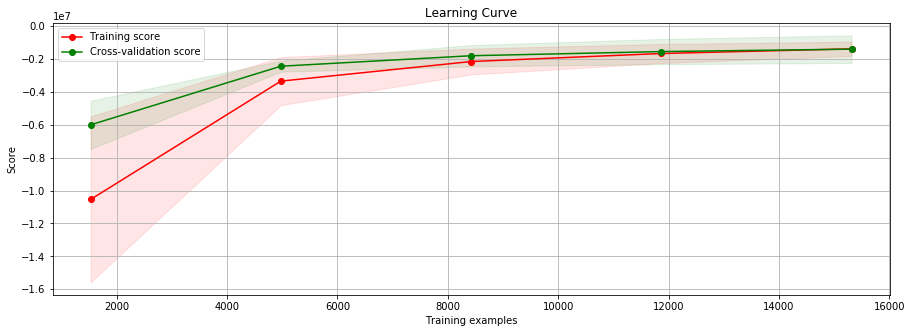

In [29]:
run_cv(DummyRegressor(),train_fillna)

(2056425.2758520395, 664398.8341098558)

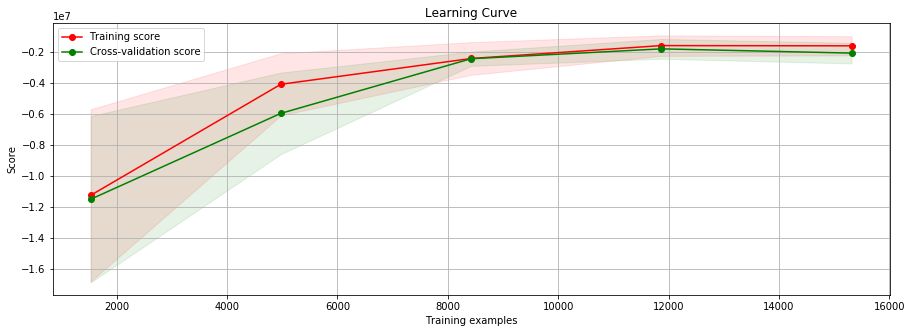

In [26]:
run_cv(lgb.LGBMRegressor(),train_fillna)

In [39]:
feats = ['broker_id', 'broker_company_id', 'type_building', 'year_building', 'material_building', 'benefit_patio', 'benefit_recepcja', 'benefit_ogrzewanie_miejskie', 'apartament_area', 'apartament_floor', 'apartament_num_levels', 'apartament_finished', 'stats_who', 'stats_market', 'garaż', 'miejsce_parkingowe', 'brak', 'apartament_condition_db', 'lazienka_z_oknem', 'condition_odnowione']
run_cv_log(lgb.LGBMRegressor(random_state=0),df_modified,feats)

(786796.4902949685, 1004542.8740095661)

In [41]:
feats = ['broker_id', 'broker_company_id', 'type_building', 'year_building', 'material_building', 'benefit_patio', 'benefit_recepcja', 'benefit_ogrzewanie_miejskie', 'apartament_area', 'apartament_floor', 'apartament_num_levels', 'apartament_finished', 'stats_who', 'stats_market', 'garaż', 'miejsce_parkingowe', 'brak', 'apartament_condition_db', 'lazienka_z_oknem', 'condition_odnowione']
run_cv_log(xgb.XGBRegressor(random_state=0,objective='reg:squarederror'),df_modified,feats)

(810776.5855310339, 1003214.4629394161)

In [45]:
%%time
from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials


feats = ['broker_id', 'broker_company_id', 'type_building', 'year_building', 'material_building',
         'benefit_patio', 'benefit_recepcja', 'benefit_ogrzewanie_miejskie', 'apartament_area', 'apartament_floor',
         'apartament_num_levels', 'apartament_finished', 'stats_who', 'stats_market', 'garaż', 'miejsce_parkingowe',
         'brak', 'apartament_condition_db', 'lazienka_z_oknem', 'condition_odnowione']

def objective(space):
    
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'random_state': int(space['random_state']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 100
    }
    
    
    score = run_cv_log(lgb.LGBMRegressor(**xgb_params),df_modified,feats)
    
    return{'loss':score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    'random_state': hp.quniform ('x_random_state', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)


100%|█████████████████████████████████████████████████| 30/30 [00:25<00:00,  1.17trial/s, best loss: 784592.1641133445]
The best params:  {'x_colsample_bytree': 0.8367333653120942, 'x_learning_rate': 0.0745689473716029, 'x_max_depth': 13.0, 'x_min_child_weight': 3.0, 'x_random_state': 1950.0, 'x_reg_alpha': 2.2823344020772858, 'x_reg_lambda': 0.8017859227733228, 'x_subsample': 0.8930361372796372}
Wall time: 25.7 s


In [46]:
feats = ['broker_id', 'broker_company_id', 'type_building', 'year_building', 'material_building',
         'benefit_patio', 'benefit_recepcja', 'benefit_ogrzewanie_miejskie', 'apartament_area', 'apartament_floor',
         'apartament_num_levels', 'apartament_finished', 'stats_who', 'stats_market', 'garaż', 'miejsce_parkingowe',
         'brak', 'apartament_condition_db', 'lazienka_z_oknem', 'condition_odnowione']

def objective(space):
    
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'random_state': int(space['random_state']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 100,
        'objective': 'reg:squarederror'
    }
    
    
    score = run_cv_log(xgb.XGBRegressor(**xgb_params),df_modified,feats)
    
    return{'loss':score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    'random_state': hp.quniform ('x_random_state', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)

100%|█████████████████████████████████████████████████| 30/30 [06:51<00:00, 13.71s/trial, best loss: 725747.5184240153]
The best params:  {'x_colsample_bytree': 0.9198180472059161, 'x_learning_rate': 0.14632333439051548, 'x_max_depth': 8.0, 'x_min_child_weight': 3.0, 'x_random_state': 5850.0, 'x_reg_alpha': 2.3669509005039466, 'x_reg_lambda': 0.9051004302212033, 'x_subsample': 0.737005679975973}
